## Anomaly Detection in MVTec Dataset

Different experiments will be done in this workspace.

Used Models:
* `ConvAE Model`
* `CBAM ConvAE Model`
* `Residual CBAM ConvAE Model`

Batch size: `16`

Epochs: Changes between `500~1000` epochs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/attention_modules.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/backbones.py

os.chdir('/content')
print("Current working directory", os.getcwd())

Current working directory /content


In [4]:
from utils import vision
from utils import utils
from utils import losses
from utils import models
from utils import backbones
from utils import attention_modules
from utils.attention_modules import Conv2DLayerBN, Conv2DLayerRes, ChannelGate, SpatialGate, CBAM

### Experiment Setup Start

In [5]:
# Create experiment folder
EXPERIMENT_NAME = 'CBAM_ConvAE_Model_MVTec'
EXPERIMENT_SAVE_DIR = os.path.join('/content/drive/MyDrive/MASTER/Master_Thesis/Experiments', EXPERIMENT_NAME)
EXPERIMENT_PRELOAD_WEIGHTS_FROM = 'experiment_13'  # ex. 'experiment_2'

In [6]:
experiment = {
    'TYPE': 'test',        # Experiment type: 'train', 'test', 'dev'
    'ACCELERATOR': 'GPU',   # 'CPU', 'GPU' or 'TPU'

    # Input data
    'DATASET': 'MVTec_metal_nut_Dataset',  # 'MVTec_transistor_Dataset',
    'IMAGE_SIZE': (256, 256),
    'INPUT_SHAPE': (256, 256, 3),
    'PATCH_SIZE': 256,
    'MAX_GRID_NUM': 4,      # Number of maximum grids to be used in partitioning the input image
    'USE_ENTIRE_IMAGES'     : False,  # Use entire/unpartitioned images as input
    'USE_PARTITIONED_IMAGES': True,  # Use partitioned (parameters: PATCH_SIZE, MAX_GRID_NUM) images as input
    'VALID_SIZE': 0.1,      # Validation data size: (Valid Data) / (All Data)
    'DATA_AUG': False,      # Apply data augmentation
    'DATA_AUG_POWER': 2,    # Data augmentation power: How many times data
     # augmentation will be applied to the whole dataset. default 1

    # Model
    'BACKBONE': 'Hybrid_AE_GAN',   # 'ConvAE', 'CBAM_ConvAE' or 'ResCBAM_ConvAE'
    'DECODER_ATTENTION': True,      # Valid if backbone has CBAM. If True, CBAM attention layer in both encoder and decoder layer
    'REDUCTION_RATIO': 16,          # CBAM layer reduction ratio
    'SPARSITY_FACTOR': None,        # The activity regularizer for sparsity in autoencoders - tf.keras.regularizers.l1(0.001)
    'FIRST_TRANIABLE_LAYER_IX': None,  # First trainable layer of pre-trained backbone models - "block4_pool"
    'BATCH_SIZE': 16,               # IF TPU is active set 4, otherwise set anything
    'EPOCHS': 500,
    'OPTIMIZER': tf.keras.optimizers.Adam,
    'LEARNING_RATE': 1e-4,
    'LATENT_DIM': 256,  # set latent dim - shape: (LATENT_DIM, 1) - default 200

    # Loss
    'RECONS_LOSS': tf.keras.losses.mean_squared_error, # Reconstruction loss (use tf intrinsic methods: tf.keras.losses.mean_squared_error or losses.ssim_loss)
    'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value
    # Perceptual Loss
    'PERCEPTUAL_LOSS': False, # Use Perceptual loss
    'PERCEPTUAL_LOSS_MODEL': 'ResNet50', # 'custom', 'VGG16', 'VGG19', 'ResNet50' - default 'VGG16'
    'PERCEPTUAL_LAYERS': [35,77,139,150],    # 'conv2_block3_3_conv', 'conv3_block4_3_conv', 'conv4_block6_3_conv', 'conv5_block1_3_conv'
    'PERP_LOSS_LAMBDA': 1,      # Perceptual loss coeff
    'MSE_LOSS_LAMBDA': 0.5,     # MSE coeff

    # Evaluation
    'BIN_MASK_THRSD': 0.5,  # Binary mask threshold
    'MAX_TEST_IMAGES': -1,  # default: -1, Get all images from the testing dataset

    # Save model
    'PRE_LOAD_WEIGHTS': None, # Start to train model with initial weights come from previous training process - Set epoch number (50, 100, etc.)
    'SAVE_WEIGHTS_PER_EPOCH': 25,  # Checkpoints
}

In [7]:
if experiment['TYPE'] == 'train':
    assert(EXPERIMENT_NAME != '...')
    # Create experiment folder
    os.makedirs(EXPERIMENT_SAVE_DIR, exist_ok=True)

    # Model checkpoints will be save in exp_save_dir
    exp_save_dir = utils.create_experimental_output(experiment, EXPERIMENT_SAVE_DIR)

    TRAINING_WEIGHT_DIR = os.path.join(exp_save_dir, 'training_weights')
    # Create folder for checkpoints (training weights)
    os.makedirs(TRAINING_WEIGHT_DIR, exist_ok=True)

    if experiment['PRE_LOAD_WEIGHTS'] != None:
        assert(EXPERIMENT_PRELOAD_WEIGHTS_FROM != None)
        # Start to train model with initial weights come from previous training process
        exp_save_dir = os.path.join(EXPERIMENT_SAVE_DIR, EXPERIMENT_PRELOAD_WEIGHTS_FROM)
        PRE_LOAD_WEIGHT_DIR = os.path.join(exp_save_dir, 'training_weights')
elif experiment['TYPE'] == 'dev': # development type
    pass
else:  # test mode
    assert(EXPERIMENT_PRELOAD_WEIGHTS_FROM != None)
    # Set experiment save directory and training weight directory manually
    exp_save_dir = exp_save_dir = os.path.join(EXPERIMENT_SAVE_DIR, EXPERIMENT_PRELOAD_WEIGHTS_FROM)
    TRAINING_WEIGHT_DIR = os.path.join(exp_save_dir, 'training_weights')

In [8]:
if experiment['TYPE'] != 'dev':
    print(f"...Experiment {exp_save_dir.split('experiment_')[1]} was initialized...")
    print(f"Experiment directory: {EXPERIMENT_SAVE_DIR}")
    print(f"Training weights save directory: {TRAINING_WEIGHT_DIR}")

...Experiment 13 was initialized...
Experiment directory: /content/drive/MyDrive/MASTER/Master_Thesis/Experiments/CBAM_ConvAE_Model_MVTec
Training weights save directory: /content/drive/MyDrive/MASTER/Master_Thesis/Experiments/CBAM_ConvAE_Model_MVTec/experiment_13/training_weights


### Experiment Setup End

### Dataset Pre-processing Start

In [9]:
# MVTec Transistor dataset from Kaggle
# https://www.kaggle.com/datasets/leezhixiong/mvtec-transistor-dataset

! pip install -q kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ipythonx/mvtec-ad

utils.unzip_data("/content/mvtec-ad.zip")
! rm /content/mvtec-ad.zip

100% 4.90G/4.91G [01:08<00:00, 112MB/s]
100% 4.91G/4.91G [01:08<00:00, 77.4MB/s]


Set MVTec Dataset Paths for sub datasets

In [10]:
ROOT_PATH = "/content"

# Parse experiment dataset config, get sub dataset folder name
subfolder_name = ((experiment['DATASET'].split("MVTec_")[-1]).split("_Dataset")[0])
TRAIN_DATASET_GOOD_PATH = os.path.join(ROOT_PATH, (subfolder_name + "/train/good"))
TRAIN_DATASET_DEFECT_PATH = None

TEST_DATASET_GOOD_PATH = os.path.join(ROOT_PATH, (subfolder_name + "/test/good"))
TEST_DATASET_DEFECT_PATH = os.path.join(ROOT_PATH, (subfolder_name + "/test"))
GND_DATASET_DEFECT_PATH = os.path.join(ROOT_PATH, (subfolder_name + "/ground_truth"))

In [11]:
print("TRAIN DATASET GOOD")
# Do not need to separate training dataset into train_good and train_defect (unsupervised learning)
# Do not need to sort train dataset files, they already will be shuffled
train_dataset_files = utils.get_all_img_files_in_directory(TRAIN_DATASET_GOOD_PATH, ext="png", verbose=1)

#print("TEST DATASET GOOD")
#test_dataset_good_files = utils.get_all_img_files_in_directory(TEST_DATASET_GOOD_PATH, ext="png", verbose=1)

print("TEST DATASET DEFECTED")
# Exclude Test Dataset Good Files, get all others
test_dataset_defect_files = utils.get_all_img_files_in_directory(TEST_DATASET_DEFECT_PATH, ext="png", exc="good", verbose=1)
# Sort ground truth dataset according to image file names
test_dataset_defect_files = sorted(test_dataset_defect_files)

print("GROUND TRUTH DATASET DEFECTED")
gnd_dataset_defect_files = utils.get_all_img_files_in_directory(GND_DATASET_DEFECT_PATH, ext="png", verbose=1)
# Sort ground truth dataset according to image file names
gnd_dataset_defect_files = sorted(gnd_dataset_defect_files)

TRAIN DATASET GOOD
There are 0 directories and 220 files in '/content/metal_nut/train/good'.
TEST DATASET DEFECTED
There are 5 directories and 0 files in '/content/metal_nut/test'.
There are 0 directories and 25 files in '/content/metal_nut/test/bent'.
There are 0 directories and 23 files in '/content/metal_nut/test/flip'.
There are 0 directories and 22 files in '/content/metal_nut/test/color'.
Files in the '/content/metal_nut/test/good' path was not included in the file list
There are 0 directories and 22 files in '/content/metal_nut/test/good'.
There are 0 directories and 23 files in '/content/metal_nut/test/scratch'.
GROUND TRUTH DATASET DEFECTED
There are 4 directories and 0 files in '/content/metal_nut/ground_truth'.
There are 0 directories and 25 files in '/content/metal_nut/ground_truth/bent'.
There are 0 directories and 23 files in '/content/metal_nut/ground_truth/flip'.
There are 0 directories and 22 files in '/content/metal_nut/ground_truth/color'.
There are 0 directories and

In [12]:
LABELS = ["Defect-free", "Defected"]

Training dataset Validation Split

In [13]:
# Training/Validation Split
train_valid_separator = len(train_dataset_files) - int(len(train_dataset_files) * experiment['VALID_SIZE'])

print(f"Number of defect free {subfolder_name} images in the training dataset: {len(train_dataset_files[:train_valid_separator])}")
print(f"Number of defect free {subfolder_name} images in the validation dataset: {len(train_dataset_files[train_valid_separator:])}")
print(f"Number of defect free {subfolder_name} images: {len(train_dataset_files[:train_valid_separator])+len(train_dataset_files[train_valid_separator:])}")
print(f"Number of defected {subfolder_name} images in the testing dataset: {len(test_dataset_defect_files)}")
#print(f"Number of defect free {subfolder_name} images in the testing dataset: {len(test_dataset_good)}")

Number of defect free metal_nut images in the training dataset: 198
Number of defect free metal_nut images in the validation dataset: 22
Number of defect free metal_nut images: 220
Number of defected metal_nut images in the testing dataset: 93


### get_new_image_size_according_to_patch_size() method usage

We use a patch-wise anomaly searching technique. BATCH_SIZE = (256, 256). We will find the best-fitting width and height values for the dataset.

Ex:

test_img.shape[0] # Heigth: 2816px

test_img.shape[1] # Width: 4096px

test_img.shape[0] // `experiment['PATCH_SIZE']` # Heigth: 11 row

test_img.shape[1] // `experiment['PATCH_SIZE']` # Width: 16 column

16*11 = 176 grid (too much to handle). We accept `maximum 36 grids`.

Number of maximum Grids: 36 - Optimal Input Shape: (256, 256, 3)

```python
utils.get_new_image_size_according_to_patch_size(test_img.shape[:2],
                                                experiment['PATCH_SIZE'],
                                                max_grid_num=36,
                                                verbose=1)
```

Output:
>> Modified Image size: (1024, 1024)

No change in the input image size. A total of `16` grid was accepted.

IF we enter fewer max number of grids value like:

```python
utils.get_new_image_size_according_to_patch_size(test_img.shape[:2],
                                                experiment['PATCH_SIZE'],
                                                max_grid_num=2,
                                                verbose=1)
```

Output:
>> Modified Image size: (256, 256)

A total of `1` grid was accepted.

```python
utils.get_new_image_size_according_to_patch_size(test_img.shape[:2],
                                                experiment['PATCH_SIZE'],
                                                max_grid_num=4,
                                                verbose=1)
```

Output:
>> Modified Image size: (512, 512)

A total of `4` grid was accepted.

Test image shape: (700, 700, 3)


(-0.5, 699.5, 699.5, -0.5)

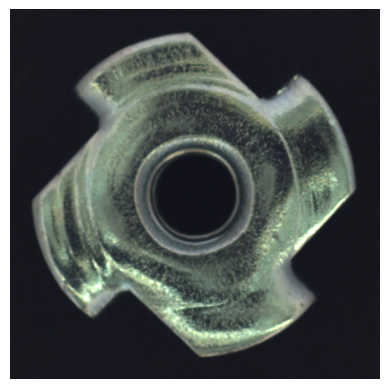

In [14]:
test_img = utils.load_images(train_dataset_files[1], scl=True)
print(f"Test image shape: {test_img.shape}")

plt.imshow(test_img)
plt.axis('off')

Get Modified Image size and number of Width/Height grids

In [15]:
modified_image_size, grid_width, grid_height = utils.get_new_image_size_according_to_patch_size(test_img.shape[:2],
                                                                                                experiment['PATCH_SIZE'],
                                                                                                max_grid_num=experiment['MAX_GRID_NUM'],
                                                                                                verbose=1)

number_of_grids = grid_width*grid_height

print(f"Number of total partitions/grids: {number_of_grids}")

Original Image size: (700, 700)
Original image aspect ratio: 1.0
Width grid: 2, Heigth grid: 2
Defect Detail Power/Coeff: 4 (Maximum: 36 (grids))
Modified aspect ratio: 1.0
Modified Image size: (512, 512)
Number of total partitions/grids: 4


Data Augmentation Layer

In [16]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

if experiment['DATA_AUG']:
    # Setup data augmentation
    data_aug_layer = Sequential([
      #preprocessing.RandomFlip("horizontal_and_vertical"), # randomly flip images on horizontal/vertical edge
      #preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
      #preprocessing.RandomZoom(0.2), # randomly zoom into an image
      tf.keras.layers.RandomBrightness(factor=0.2, value_range=[0.0, 1.0], seed=None),
      # value_range parameter should be [0.0, 1.0] for RandomBrightness
      # if images were scaled before, default value is [0,255]
      tf.keras.layers.RandomContrast(0.2, seed=None),
      #tf.keras.layers.RandomCrop(256, 256, seed=None), Error - Image size changes
      #preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
      #preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
      #preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
    ], name="data_aug_layer")
else:
    data_aug_layer = None

In [17]:
import random

random.seed(24)

random.shuffle(train_dataset_files)
train_dataset_files = train_dataset_files[:train_valid_separator]

In [18]:
print(f"Number of {subfolder_name} images in the training dataset: {len(train_dataset_files)}")

Number of metal_nut images in the training dataset: 198


Create TF Dataset Pipeline

In [19]:
# Use partititoned images as input (Parameters: PATCH_SIZE and MAX_GRID_NUM)
if experiment['USE_PARTITIONED_IMAGES']:
    train_dataset = utils.create_dataset_pipeline(train_dataset_files, batch_size=experiment['BATCH_SIZE'], shuffle=True,
                                                  img_size=modified_image_size, scl=True, patch_size=experiment['PATCH_SIZE'],
                                                  entire_img_pathes=experiment['USE_ENTIRE_IMAGES'], aug_layer=data_aug_layer,
                                                  data_aug_power=experiment['DATA_AUG_POWER'], accelerator='GPU')
# Use only entire images dataset as input
else:
    train_dataset = utils.create_dataset_pipeline(train_dataset_files, batch_size=experiment['BATCH_SIZE'], shuffle=True,
                                                      img_size=experiment['IMAGE_SIZE'], scl=True, patch_size=None,
                                                      aug_layer=data_aug_layer, data_aug_power=experiment['DATA_AUG_POWER'],
                                                      accelerator='GPU')

['absl-py', 'aiohttp', 'aiosignal', 'alabaster', 'albumentations', 'altair', 'annotated-types', 'anyio', 'appdirs', 'argon2-cffi', 'argon2-cffi-bindings', 'array-record', 'arviz', 'astropy', 'astunparse', 'async-timeout', 'atpublic', 'attrs', 'audioread', 'autograd', 'Babel', 'backcall', 'beautifulsoup4', 'bidict', 'bigframes', 'bleach', 'blinker', 'blis', 'blosc2', 'bokeh', 'bqplot', 'branca', 'build', 'CacheControl', 'cachetools', 'catalogue', 'certifi', 'cffi', 'chardet', 'charset-normalizer', 'chex', 'click', 'click-plugins', 'cligj', 'cloudpathlib', 'cloudpickle', 'cmake', 'cmdstanpy', 'colorcet', 'colorlover', 'colour', 'community', 'confection', 'cons', 'contextlib2', 'contourpy', 'cryptography', 'cufflinks', 'cupy-cuda12x', 'cvxopt', 'cvxpy', 'cycler', 'cymem', 'Cython', 'dask', 'datascience', 'db-dtypes', 'dbus-python', 'debugpy', 'decorator', 'defusedxml', 'distributed', 'distro', 'dlib', 'dm-tree', 'docutils', 'dopamine-rl', 'duckdb', 'earthengine-api', 'easydict', 'ecos', '

In [20]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [21]:
print("Number of batches to be trained: ", len(train_dataset))

Number of batches to be trained:  50


### Dataset Pre-processing End

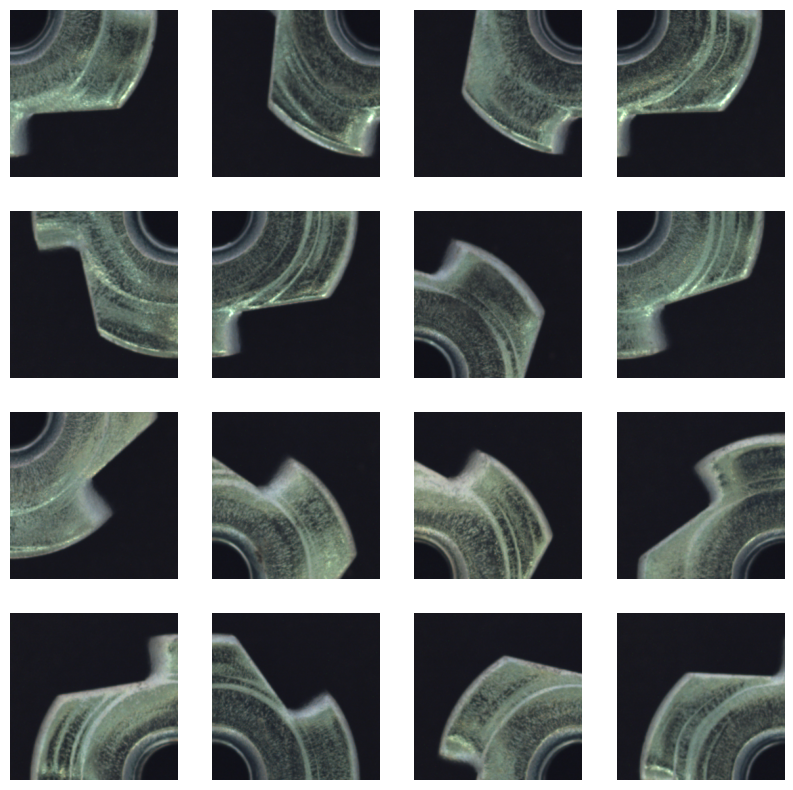

In [22]:
vision.show_image_samples_from_batch(train_dataset)

### Model Training Start

Create Custom Anomaly Detection Model

In [23]:
# Create autoencoder model
def create_ae_model(input_shape=(256, 256, 3)):
    num_dense = int(input_shape[0]/(2**5))
    input_img = Input(shape=input_shape)

    # Encoder
    x = attention_modules.Conv2DLayerBN(32, (3,3), strides=2, padding="same", use_bias=True, act_end='lrelu', lrelu_alpha=0.3)(input_img)
    x = attention_modules.Conv2DLayerBN(64, (3,3), strides=2, padding="same", use_bias=True, act_end='lrelu', lrelu_alpha=0.3)(x)
    x = attention_modules.Conv2DLayerBN(128, (3,3), strides=2, padding="same", use_bias=True, act_end='lrelu', lrelu_alpha=0.3)(x)
    x = attention_modules.Conv2DLayerBN(256, (3,3), strides=2, padding="same", use_bias=True, act_end='lrelu', lrelu_alpha=0.3)(x)
    x = attention_modules.Conv2DLayerBN(256, (3,3), strides=2, padding="same", use_bias=True, act_end='lrelu', lrelu_alpha=0.3)(x)
    x = tf.keras.layers.Flatten()(x)
    x = Dense(num_dense*num_dense*256, activation='relu')(x)
    # Latent vector
    x = Dense(experiment['LATENT_DIM'], activation='relu')(x)

    # Decoder
    #x = Dense(tf.reduce_prod(input_shape), activation='relu')(encoded)
    x = Dense(num_dense*num_dense*256, activation='relu')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.3)(x)
    x = tf.keras.layers.Reshape((num_dense, num_dense, 256))(x)

    x = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(3,3), strides=2, padding="same", use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Set activation func to ReLu for Conv2dTrasnpose blocks
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(3,3), strides=2, padding="same", use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Set activation func to ReLu for Conv2dTrasnpose blocks
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2, padding="same", use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Set activation func to ReLu for Conv2dTrasnpose blocks
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, padding="same", use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Set activation func to ReLu for Conv2dTrasnpose blocks
    x = tf.keras.layers.ReLU()(x)

    output = tf.keras.layers.Conv2DTranspose(filters=input_shape[2], kernel_size=(3,3),
                                             strides=2, padding="same", use_bias=True,
                                              activation='sigmoid')(x)

    return Model(input_img, output, name="autoencoder")

ae_model = create_ae_model()

# Create discriminator model
def create_discriminator_model(input_shape=(256, 256, 3)):
    input_img = Input(shape=input_shape)
    x = attention_modules.Conv2DLayerBN(32, (3, 3), strides=2, padding='same', act_end='relu')(input_img)
    x = attention_modules.Conv2DLayerBN(64, (3, 3), strides=2, padding='same', act_end='relu')(x)
    x = attention_modules.Conv2DLayerBN(128, (3, 3), strides=2, padding='same', act_end='relu')(x)
    x = attention_modules.Conv2DLayerBN(256, (3, 3), strides=2, padding='same', act_end='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    return Model(input_img, output, name="discriminator")


# Build and compile discriminator model
disc_model = create_discriminator_model()

In [24]:
if experiment['BACKBONE'] == 'ConvAE':
    # ConvAE Model
    custom_model = backbones.build_ConvAEModelV1(input_shape=experiment['INPUT_SHAPE'],
                                             latent_dim=experiment['LATENT_DIM'],
                                             lrelu_alpha=experiment['LRELU_SLOPE'],
                                             sparsity=experiment['SPARSITY_FACTOR'])
elif experiment['BACKBONE'] == 'CBAM_ConvAE':
    # CBAM ConvAE Model
    custom_model = backbones.build_CBAMConvAEModelV1(input_shape=experiment['INPUT_SHAPE'],
                                                 latent_dim=experiment['LATENT_DIM'],
                                                 reduction_ratio=experiment['REDUCTION_RATIO'],
                                                 attention_for_decoder=experiment['DECODER_ATTENTION'],
                                                 lrelu_alpha=experiment['LRELU_SLOPE'],
                                                 sparsity=experiment['SPARSITY_FACTOR'])
elif experiment['BACKBONE'] == 'ResCBAM_ConvAE':
    # Residual CBAM ConvAE Model
    custom_model = backbones.build_ResCBAMConvAEModelV1(input_shape=experiment['INPUT_SHAPE'],
                                                    latent_dim=experiment['LATENT_DIM'],
                                                    reduction_ratio=experiment['REDUCTION_RATIO'],
                                                    attention_for_decoder=experiment['DECODER_ATTENTION'],
                                                    lrelu_alpha=experiment['LRELU_SLOPE'],
                                                    sparsity=experiment['SPARSITY_FACTOR'])

else:
    # ...USER_CODE_HERE...
    custom_model = ae_model

custom_model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_layer_bn (Conv2DLay  (None, 128, 128, 32)      1024      
 erBN)                                                           
                                                                 
 conv2d_layer_bn_1 (Conv2DL  (None, 64, 64, 64)        18752     
 ayerBN)                                                         
                                                                 
 conv2d_layer_bn_2 (Conv2DL  (None, 32, 32, 128)       74368     
 ayerBN)                                                         
                                                                 
 conv2d_layer_bn_3 (Conv2DL  (None, 16, 16, 256)       296192    
 ayerBN)                                               

In [25]:
def generate_and_save_images(model, epoch, test_input):
  # All layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  print("test_input.shape: ", test_input.shape)
  print("predictions.shape: ", predictions.shape)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.array((predictions[i, :, :, :] * 255)).astype(np.uint8))
    plt.axis('off')
    if i >= 15:
      break

  #plt.savefig(experiment['IMGS_DIR'] + '/image_at_epoch_{:d}.png'.format(epoch))
  plt.show()

In [26]:
if experiment['ACCELERATOR'] != 'TPU':
  @tf.function
  def train_step(images):
      with tf.GradientTape() as tape:
          generated_images = custom_model(images, training=True)
          #loss = custom_model.compute_mse_perceptual(images, generated_images)
          loss = custom_model.loss(images, generated_images)

      gradients = tape.gradient(loss, custom_model.trainable_variables)
      custom_model.optimizer.apply_gradients(zip(gradients, custom_model.trainable_variables))

      return loss

In [27]:
from IPython import display
import time

if experiment['ACCELERATOR'] != 'TPU':
  def train(dataset, epochs):
      loss_hist = []  # Keep loss history
      for epoch in range(epochs):
          start = time.time()
          for image_batch in dataset:
              loss = train_step(image_batch)

          loss_hist.append(loss)   # Add loss value to the loss history after each epoch
          print("loss: ", tf.reduce_mean(loss).numpy())

          # Set real epoch value for progressive training process
          real_epoch = epoch
          if experiment['PRE_LOAD_WEIGHTS'] != None:
              real_epoch += experiment['PRE_LOAD_WEIGHTS']

          # Save the model every experiment['SAVE_WEIGHTS_PER_EPOCH'] epochs
          if (real_epoch + 1) % experiment['SAVE_WEIGHTS_PER_EPOCH'] == 0:
            seed = image_batch[:experiment['BATCH_SIZE']]
            display.clear_output(wait=True)
            generate_and_save_images(custom_model,
                                      real_epoch + 1,
                                      seed)

            # Save checkpoints
            utils.save_experiment_checkpoints([custom_model], epoch=(real_epoch+1), save_dir=TRAINING_WEIGHT_DIR)

            print ('Time for epoch {} is {} sec'.format(real_epoch + 1, time.time()-start))

      # Generate after the final epoch
      display.clear_output(wait=True)
      generate_and_save_images(custom_model,
                              real_epoch+1,
                              seed)

      return loss_hist

In [28]:
if experiment['TYPE'] == 'train':
    custom_model.compile(loss=experiment['RECONS_LOSS'],
                         optimizer=experiment['OPTIMIZER'](learning_rate=experiment['LEARNING_RATE']))

    # Start training the model with previously trained weights
    if experiment['PRE_LOAD_WEIGHTS'] != None:
        # Start to train model with initial weights come from previous training process
        utils.load_model_experiment_weights([custom_model], epoch=experiment['PRE_LOAD_WEIGHTS'], load_dir=PRE_LOAD_WEIGHT_DIR)

    custom_model_hist = train(train_dataset, experiment['EPOCHS'])
else:  # test/inference mode
    # Set load weight epoch number manually
    utils.load_model_experiment_weights([custom_model], epoch=experiment['EPOCHS'], load_dir=TRAINING_WEIGHT_DIR)

In [29]:
if experiment['TYPE'] == 'train':
    utils.remove_training_weights_except_last_epoch(TRAINING_WEIGHT_DIR)  # Remove weights except last epoch's

### Model Training End

### Experiment Analysis and Evaluation Start

Model Training Loss Histroy

In [30]:
if experiment['TYPE'] == 'train':
    plt.plot(custom_model_hist)

In [31]:
def get_generated_image_batch(data):
    reconstructed_batch = None

    for image_batch in data:
      generated_batch = custom_model.predict(image_batch)

      if reconstructed_batch is None:
          reconstructed_batch = generated_batch
      else:
          reconstructed_batch = np.concatenate((reconstructed_batch, generated_batch))

      if reconstructed_batch.shape[0] > 5000:
          break

    return reconstructed_batch

Get Generated Data using Training dataset

In [32]:
generated_train_data = get_generated_image_batch(train_dataset.take(1))  # Use only first batch
generated_train_data.shape

1/1 [==============================] - 2s 2s/step


(16, 256, 256, 3)

In [33]:
def show_generated_images(image_batch):
  fig = plt.figure(figsize=(10, 10))
  for index, image in enumerate(image_batch):
    plt.subplot(4, 4, index + 1)
    plt.imshow(image)
    plt.axis('off')
    if index >= 15:
      break
  plt.show()

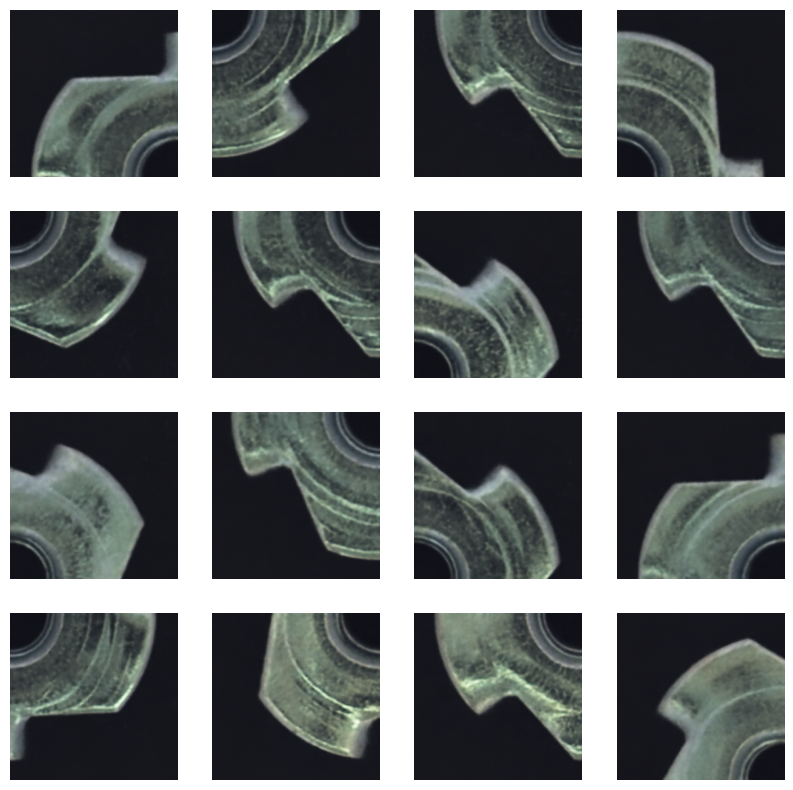

In [34]:
show_generated_images(generated_train_data)

Get test images by the specified value

In [35]:
if experiment['MAX_TEST_IMAGES'] != -1:
    test_dataset_defect_files = test_dataset_defect_files[:experiment['MAX_TEST_IMAGES']]

Create TF Dataset Pipeline for Test images - Do not shuffle test dataset

In [36]:
# Use partititoned images as input (Parameters: PATCH_SIZE and MAX_GRID_NUM)
if experiment['USE_PARTITIONED_IMAGES']:
    test_dataset = utils.create_dataset_pipeline(test_dataset_defect_files, batch_size=experiment['BATCH_SIZE'],
                                              img_size=modified_image_size, scl=True, patch_size=experiment['PATCH_SIZE'],
                                              entire_img_pathes=experiment['USE_ENTIRE_IMAGES'], aug_layer=None, accelerator='GPU')
# Use only entire images dataset as input
else:
    test_dataset = utils.create_dataset_pipeline(test_dataset_defect_files, batch_size=experiment['BATCH_SIZE'],
                                              img_size=experiment['IMAGE_SIZE'], scl=True, patch_size=None,
                                              aug_layer=None, accelerator='GPU')

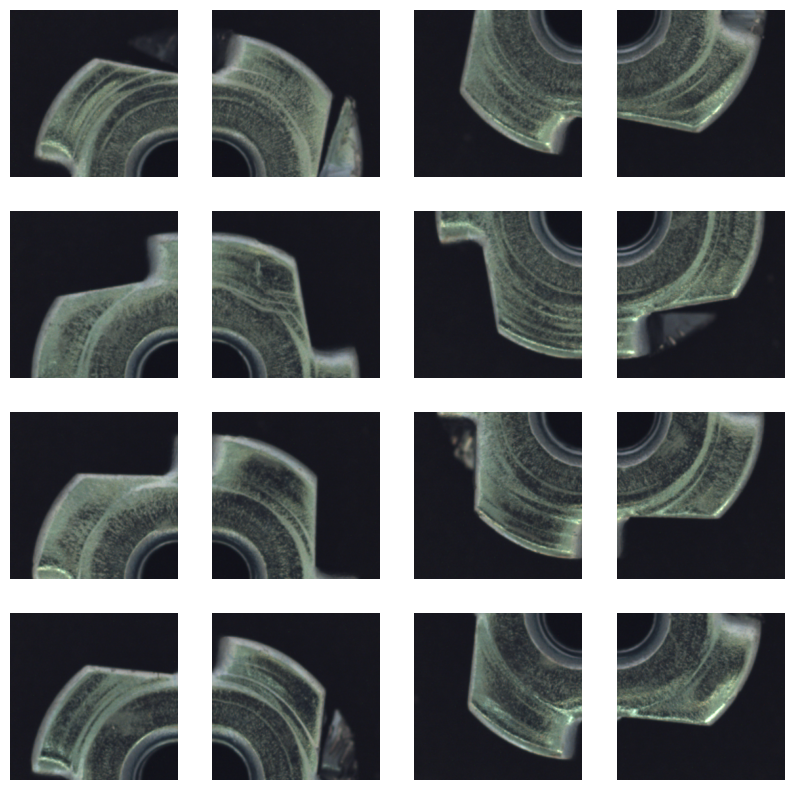

In [37]:
vision.show_image_samples_from_batch(test_dataset)

Generate Images from the Test Dataset

1/1 [==============================] - 0s 403ms/step


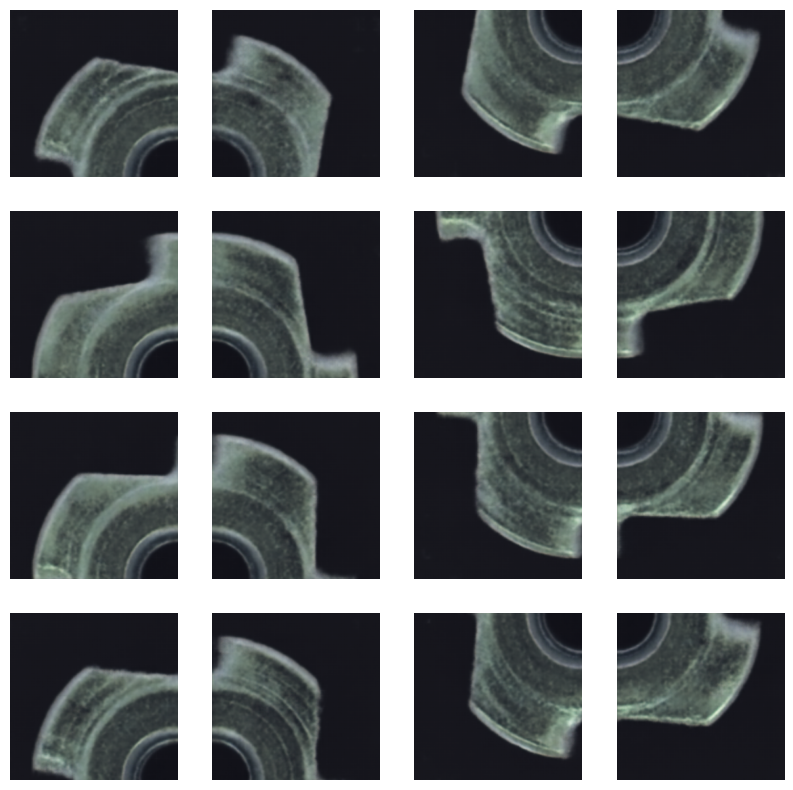

In [38]:
TEST_IMG_IX = 0

generated_test_data = get_generated_image_batch(test_dataset)
show_generated_images(generated_test_data)

(-0.5, 511.5, 511.5, -0.5)

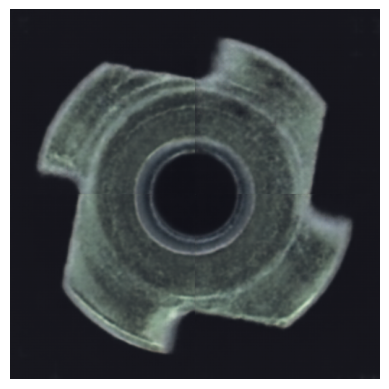

In [39]:
generated_sample_img = utils.unpatchify_img(generated_test_data[:(grid_width*grid_height)], grid=(grid_width,grid_height))
plt.imshow(generated_sample_img)
plt.axis('off')

Show partitioned image with grids

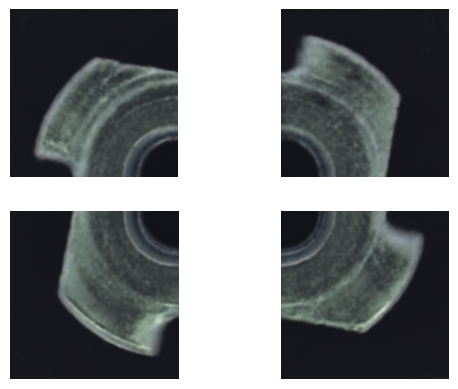

In [40]:
grid_starter = 0
partitioned_images = []

for ix in range(grid_width*grid_height):
  plt.subplot(grid_height, grid_width, (ix+1))
  plt.imshow(generated_test_data[grid_starter+TEST_IMG_IX])
  # Create partitioned images list to unpatchify
  partitioned_images.append(generated_test_data[grid_starter+TEST_IMG_IX])

  grid_starter += 1
  plt.axis('off')

plt.show()

In [41]:
def plot_input_and_generated_image_pair(input_batch, generated_batch, plot_ix=0):
    plt.subplot(1,2,1)
    plt.imshow(input_batch[plot_ix])
    plt.title("Real (Input) Image")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(generated_batch[plot_ix])
    plt.title("Generated Image")
    plt.axis('off')
    plt.show()

In [42]:
test_batch = next(iter(test_dataset))

#### Sample wise Evaluation Results

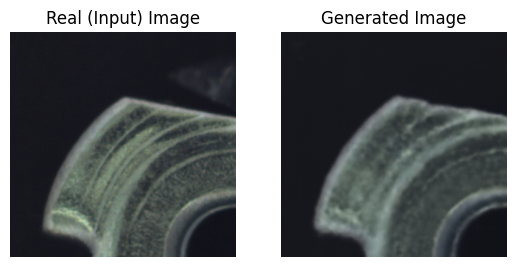

In [43]:
plot_input_and_generated_image_pair(test_batch, generated_test_data, TEST_IMG_IX)

Difference map shape: (256, 256, 3)
Normalized difference map shape: (256, 256, 3)
Normalized difference map min, avg, max value: (5.574205630409779e-08, 0.07638, 1.0)
Colored difference map shape: (256, 256, 3, 4)


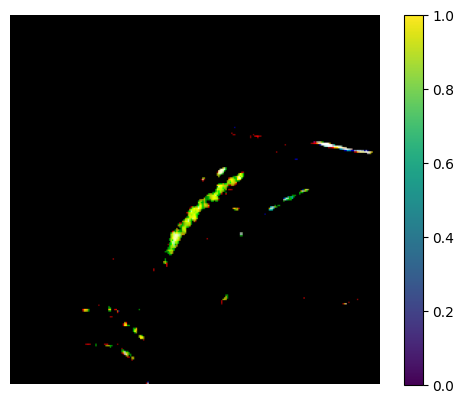

In [44]:
vision.display_pixel_wise_img_diff(test_batch[TEST_IMG_IX], generated_test_data[TEST_IMG_IX], method="mae", threshold=0.5, channel=0, verbose=1)

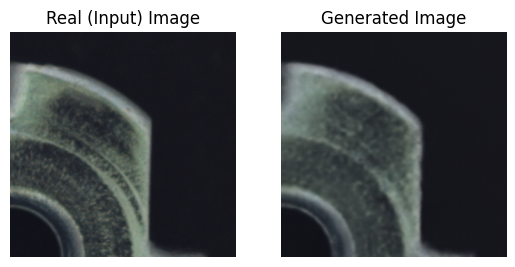

In [45]:
TEST_IMG_IX = 9

plot_input_and_generated_image_pair(test_batch, generated_test_data, TEST_IMG_IX)

Difference map shape: (256, 256, 3)
Normalized difference map shape: (256, 256, 3)
Normalized difference map min, avg, max value: (2.8465816370726316e-08, 0.09664, 1.0)
Colored difference map shape: (256, 256, 3, 4)


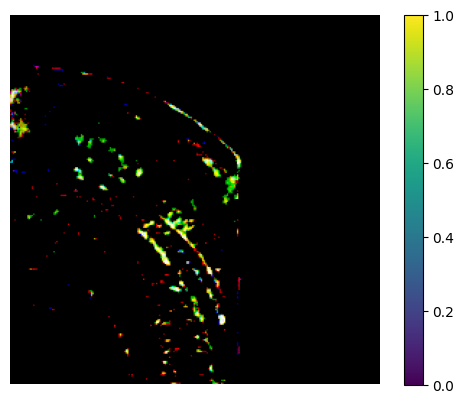

In [46]:
vision.display_pixel_wise_img_diff(test_batch[TEST_IMG_IX], generated_test_data[TEST_IMG_IX], threshold=0.5, channel=0, verbose=1)

Unbatch test dataset and get test images to detect anomalies for individual images

In [47]:
test_imgs = test_dataset.unbatch()
test_imgs = np.array(list(test_imgs.as_numpy_iterator()))

Test Image 1

In [48]:
TEST_IMG_IX = 0
if (experiment['USE_ENTIRE_IMAGES'] == True) and (experiment['USE_PARTITIONED_IMAGES'] == True):
    TEST_IMG_IX += len(test_dataset_defect_files)*(grid_width*grid_height)  # To get unpartitioned images

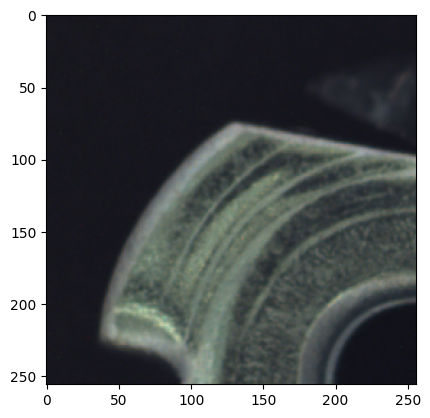

In [49]:
plt.imshow(test_imgs[TEST_IMG_IX])

Difference map shape: (256, 256, 3)
Normalized difference map shape: (256, 256, 3)
Normalized difference map min, avg, max value: (5.574205630409779e-08, 0.07638, 1.0)
Colored difference map shape: (256, 256, 3, 4)


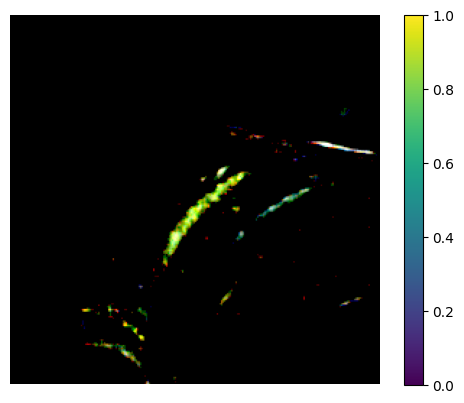

In [50]:
vision.display_pixel_wise_img_diff(test_imgs[TEST_IMG_IX], generated_test_data[TEST_IMG_IX], threshold=0.2, channel=0, verbose=1)

Visualize Feature Heatmaps

In [51]:
CONV_LAYER_NAME = "conv2d_layer_res_cbam_1"
feature_map = vision.visualize_feature_heatmap(custom_model, test_imgs[TEST_IMG_IX], conv_layer_name=CONV_LAYER_NAME,
                                        output="Loss", save_as=os.path.join(exp_save_dir, f"{CONV_LAYER_NAME}__{str(TEST_IMG_IX)}.png"))

1/1 [==============================] - 0s 173ms/step


ValueError: No such layer: conv2d_layer_res_cbam_1. Existing layers are: ['input_1', 'conv2d_layer_bn', 'conv2d_layer_bn_1', 'conv2d_layer_bn_2', 'conv2d_layer_bn_3', 'conv2d_layer_bn_4', 'flatten', 'dense', 'dense_1', 'dense_2', 'leaky_re_lu_5', 'reshape', 'conv2d_transpose', 'batch_normalization_5', 're_lu', 'conv2d_transpose_1', 'batch_normalization_6', 're_lu_1', 'conv2d_transpose_2', 'batch_normalization_7', 're_lu_2', 'conv2d_transpose_3', 'batch_normalization_8', 're_lu_3', 'conv2d_transpose_4'].

In [ ]:
CONV_LAYER_NAME = "conv2d_layer_res_cbam_2"
feature_map = vision.visualize_feature_heatmap(custom_model, test_imgs[TEST_IMG_IX], conv_layer_name=CONV_LAYER_NAME,
                                        output="Loss", save_as=os.path.join(exp_save_dir, f"{CONV_LAYER_NAME}__{str(TEST_IMG_IX)}.png"))

In [ ]:
CONV_LAYER_NAME = "conv2d_layer_res_cbam_3"
feature_map = vision.visualize_feature_heatmap(custom_model, test_imgs[TEST_IMG_IX], conv_layer_name=CONV_LAYER_NAME)

In [ ]:
CONV_LAYER_NAME = "conv2d_transpose_block_6"
feature_map = vision.visualize_feature_heatmap(custom_model, test_imgs[TEST_IMG_IX], conv_layer_name=CONV_LAYER_NAME)

In [ ]:
CONV_LAYER_NAME = "conv2d_transpose_block_5"
feature_map = vision.visualize_feature_heatmap(custom_model, test_imgs[TEST_IMG_IX], conv_layer_name=CONV_LAYER_NAME)

In [ ]:
CONV_LAYER_NAME = "conv2d_transpose_block_4"
feature_map = vision.visualize_feature_heatmap(custom_model, test_imgs[TEST_IMG_IX], conv_layer_name=CONV_LAYER_NAME)

In [ ]:
CONV_LAYER_NAME = "conv2d_transpose"
feature_map = vision.visualize_feature_heatmap(custom_model, test_imgs[TEST_IMG_IX], conv_layer_name=CONV_LAYER_NAME)

Test Image 2

In [ ]:
TEST_IMG_IX = 20
if (experiment['USE_ENTIRE_IMAGES'] == True) and (experiment['USE_PARTITIONED_IMAGES'] == True):
    TEST_IMG_IX += len(test_dataset_defect_files)*(grid_width*grid_height)  # To get unpartitioned images

CONV_LAYER_NAME = "conv2d_layer_res_cbam_1"
feature_map = vision.visualize_feature_heatmap(custom_model, test_imgs[TEST_IMG_IX], conv_layer_name=CONV_LAYER_NAME)

Test Image 3

In [ ]:
TEST_IMG_IX = 31
if (experiment['USE_ENTIRE_IMAGES'] == True) and (experiment['USE_PARTITIONED_IMAGES'] == True):
    TEST_IMG_IX += len(test_dataset_defect_files)*(grid_width*grid_height)  # To get unpartitioned images

CONV_LAYER_NAME = "conv2d_layer_res_cbam_1"
feature_map = vision.visualize_feature_heatmap(custom_model, test_imgs[TEST_IMG_IX], conv_layer_name=CONV_LAYER_NAME,
                                        output="Loss", save_as=os.path.join(exp_save_dir, f"{CONV_LAYER_NAME}__{str(TEST_IMG_IX)}.png"))

In [52]:
def unpatchify_dataset(image_batch, grid):
    entire_image_batch = []
    img_grid_id = 0

    while img_grid_id < len(image_batch):
        image = utils.unpatchify_img(image_batch[img_grid_id:(img_grid_id+(grid[0]+grid[1]))], grid=grid)
        entire_image_batch.append(image)
        img_grid_id += 4

    return np.array(entire_image_batch)

In [53]:
# Get ground truth images (gnd truth binary masks)
if experiment['MAX_TEST_IMAGES'] != -1:
    gnd_dataset_defect_files = gnd_dataset_defect_files[:experiment['MAX_TEST_IMAGES']]
ground_truth_images = utils.load_and_prepare_images(gnd_dataset_defect_files, img_size=experiment["IMAGE_SIZE"], scl=True)

# Get generated test images using custom model
generated_test_imgs = custom_model.predict(test_imgs)

# Get unpartitioned test images
if (experiment['USE_PARTITIONED_IMAGES'] == True) and (experiment['USE_ENTIRE_IMAGES'] == True):
    unpartitioned_test_imgs = test_imgs[(len(ground_truth_images)*grid_width*grid_height):]
    unpartitioned_generated_test_imgs = generated_test_imgs[(len(ground_truth_images)*grid_width*grid_height):]
    del generated_test_imgs
elif (experiment['USE_ENTIRE_IMAGES'] == True):
    unpartitioned_test_imgs = test_imgs
    unpartitioned_generated_test_imgs = generated_test_imgs
    del generated_test_imgs
else:
    # Unpatchify test images and obtain unpartitioned_test_imgs
    unpartitioned_test_imgs = unpatchify_dataset(test_imgs, grid=(grid_width, grid_height))
    # resize the unpartitioned images to be equal to the size of the ground_truth_images images
    unpartitioned_test_imgs = tf.image.resize(unpartitioned_test_imgs, experiment["IMAGE_SIZE"]).numpy()
    # Unpatchify generated test images as we did for test images
    unpartitioned_generated_test_imgs = unpatchify_dataset(generated_test_imgs, grid=(grid_width, grid_height))
    # resize the unpartitioned images to be equal to the size of the ground_truth_images images
    unpartitioned_generated_test_imgs = tf.image.resize(unpartitioned_generated_test_imgs, experiment["IMAGE_SIZE"]).numpy()
    del generated_test_imgs

print(f"Unpartitioned test images shape: {unpartitioned_test_imgs.shape}")
print(f"Unpartitioned generated test images shape: {unpartitioned_generated_test_imgs.shape}")
print(f"Ground truth test images shape: {ground_truth_images.shape}")

12/12 [==============================] - 30s 3s/step
Unpartitioned test images shape: (93, 256, 256, 3)
Unpartitioned generated test images shape: (93, 256, 256, 3)
Ground truth test images shape: (93, 256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

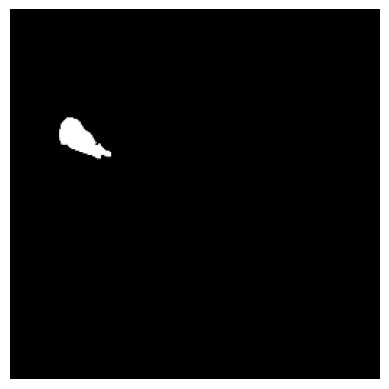

In [54]:
# Get ground truths of the defected images
TEST_IMG_IX = 31

# Convert Ground Truth Image to the Binary mask format image and visualize
plt.imshow(tf.expand_dims(ground_truth_images[TEST_IMG_IX, :, :,0], axis=2), cmap='gray')
plt.axis('off')

Plot Histogram for the test and ground truth images

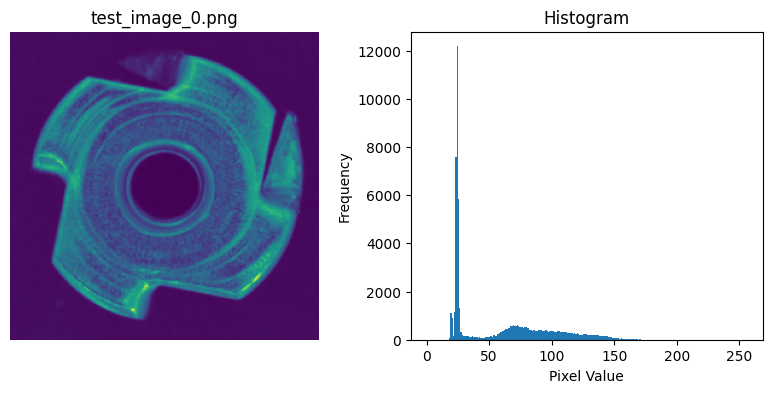

In [55]:
import cv2

TEST_IMG_IX = 0
TEST_IMG_FILE_PATH = f"test_image_{TEST_IMG_IX}.png"

cv2.imwrite(TEST_IMG_FILE_PATH, (unpartitioned_test_imgs[TEST_IMG_IX]*255).astype(np.uint8))
vision.plot_histogram(TEST_IMG_FILE_PATH)

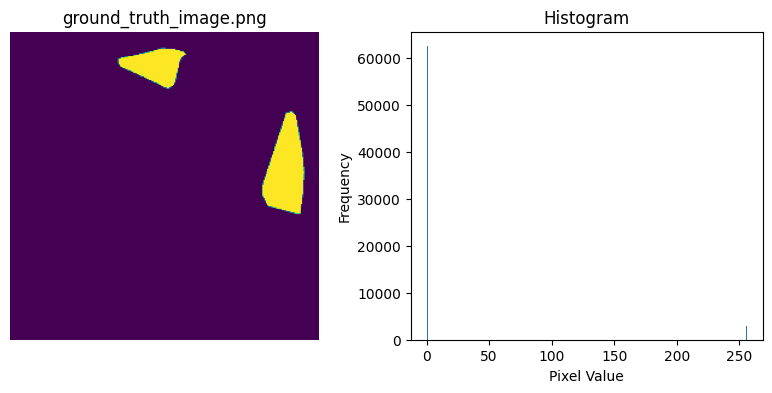

In [56]:
GND_IMG_FILE_PATH = "ground_truth_image.png"

cv2.imwrite(GND_IMG_FILE_PATH, (ground_truth_images[0]*255).astype(np.uint8))
vision.plot_histogram(GND_IMG_FILE_PATH)

Visualize Heatmaps for reconstructed images and print Pixel-wise Precision, Recall, F1 Scores and Mean IoU value

In [57]:
def visualize_loss_diff_binary_mask(image, gnd_image, model, threshold=0.5, loss="MAE", channel_diff="sum", eps=1e-6, save_as=None):
    # Generate an image from the custom model using a sample unpartitioned test image
    if experiment['USE_ENTIRE_IMAGES'] == True:
        generated_test_image = tf.squeeze(model.predict(tf.expand_dims(image, axis=0)), axis=0)
    else:
        generated_partitions = model.predict(image)
        generated_test_image = unpatchify_dataset(generated_partitions, grid=(grid_width, grid_height))
        # resize the unpartitioned images to be equal to the size of the ground_truth_images images
        generated_test_image = tf.image.resize(generated_test_image, experiment["IMAGE_SIZE"])
        generated_test_image = tf.squeeze(generated_test_image, axis=0)  # previous shape: (1, 256, 256, 3)

        # Apply same process for image
        image = unpatchify_dataset(image, grid=(grid_width, grid_height))
        # resize the unpartitioned images to be equal to the size of the ground_truth_images images
        image = tf.image.resize(image, experiment["IMAGE_SIZE"])
        image = tf.squeeze(image, axis=0)  # previous shape: (1, 256, 256, 3)

    # Convert ground truth image to the binary format
    if len(gnd_image.shape) == 3 and gnd_image.shape[-1] == 3:
        gnd_image = gnd_image[:,:,0]  # Get only one channel content
    elif len(gnd_image.shape) > 3:
        raise ValueError('Make sure that your dimension is 2d or 3d')

    assert ((loss=="MAE") or (loss=="MSE") or (loss=="MAE+RAT") or (loss=="MSE+RAT"))

    # Compute Loss diff between test and generated images (Use MAE or MSE)
    if "MAE" in loss:
        loss_diff = tf.abs(image - generated_test_image)       # MAE
    else:
        loss_diff = tf.square(image - generated_test_image)    # MSE

    # Rational Loss diff
    if "RAT" in loss:
        # Overlay test image and the generated image
        overlayed_image = generated_test_image + image + eps
        # Compute rational loss diff
        rational_loss_diff = loss_diff / overlayed_image
    else:
        rational_loss_diff = loss_diff

    # RGB to gray-scale
    assert ((channel_diff=="sum") or (channel_diff=="logic_or"))
    if channel_diff == "sum":
        # Sum the differences across channels
        rational_loss_diff = tf.reduce_sum(rational_loss_diff, axis=-1)
        rational_loss_diff_gray = tf.cast(rational_loss_diff > threshold, tf.uint8)  # Binary mask
    else:  # logic_or
        # Combine the results along the channel axis - Computes tf.math.logical_or of elements across dimensions of a tensor
        rational_loss_diff = tf.reduce_any((rational_loss_diff > threshold), axis=-1)
        # Convert it to the grayscale image
        rational_loss_diff_gray = tf.cast(rational_loss_diff, tf.uint8)  # Binary mask

    px_IoU = vision.PixelWiseIoU(tf.cast(gnd_image, tf.uint8), rational_loss_diff_gray)

    fig = plt.figure(figsize=(15, 10))

    plt.subplot(1, 5, 1)
    plt.imshow(image)
    plt.title("Test Image")
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(generated_test_image)
    plt.title("Generated Image")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(rational_loss_diff, cmap='jet')
    plt.title(f"Loss Diff ({loss})\nCh Diff ({channel_diff})")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(rational_loss_diff_gray*255, 'gray')
    plt.title(f"Loss Diff binary mask\nThr: {threshold}")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(tf.cast(gnd_image, tf.uint8)*255, 'gray')
    plt.title(f"GND truth image")
    plt.axis('off')

    if save_as != None:
        plt.savefig(save_as, bbox_inches='tight')

    plt.show()
    px_IoU.show_iou_metric_results()

Visualize Loss diff heatmap (Loss: MAE, Channel_Diff_Threshold: sum)

1/1 [==============================] - 1s 603ms/step


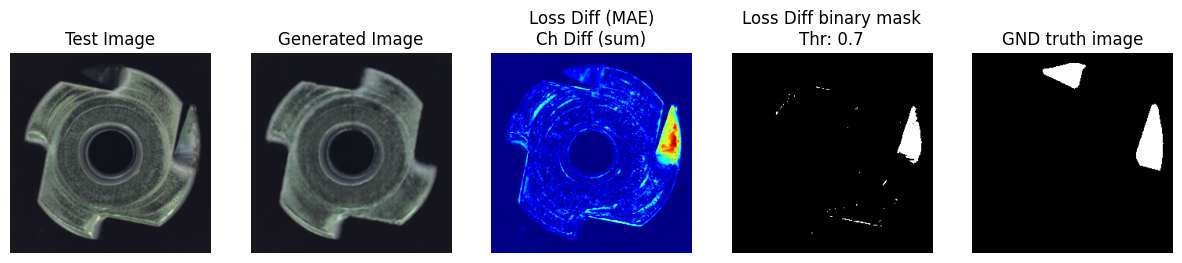

Pixel-wise Precision = 0.91068
Pixel-wise Recall = 0.41703
Pixel-wise F1 score = 0.57208
Sketchy IoU = 0.40064
Mean IoU = 0.68573


In [58]:
TEST_IMG_IX = 0
BINARY_MASK_THR = 0.7  # experiment['BIN_MASK_THRSD']

# Define preindex and postindex for partitioned images array control
if experiment['USE_ENTIRE_IMAGES'] == False:  # Using only partitioned image
    '''
    preindex = lambda: int(TEST_IMG_IX/number_of_grids)*number_of_grids
    postindex = lambda: int(preindex()+number_of_grids)
    '''
    preindex = lambda: int(TEST_IMG_IX * number_of_grids)
    postindex = lambda: int(preindex()+number_of_grids)

plot_save_dir = os.path.join(os.path.abspath(exp_save_dir), f"Loss_MAE_diff_thr_{str(BINARY_MASK_THR)}__{str(TEST_IMG_IX)}.png")

if experiment['USE_ENTIRE_IMAGES'] == True:
    visualize_loss_diff_binary_mask(image=unpartitioned_test_imgs[TEST_IMG_IX], gnd_image=ground_truth_images[TEST_IMG_IX],
                                model=custom_model, threshold=BINARY_MASK_THR, loss="MAE", channel_diff="sum", save_as=plot_save_dir)
else:  # Use test images to generate reconstructed images from the custom model, not unpartitioned_images
    visualize_loss_diff_binary_mask(image=test_imgs[preindex():postindex()], gnd_image=ground_truth_images[TEST_IMG_IX],
                                model=custom_model, threshold=BINARY_MASK_THR, loss="MAE", channel_diff="sum", save_as=plot_save_dir)

Visualize Loss diff heatmap using Rational Diff with Overlayed Image (Loss: MAE+RAT, Channel_Diff_Threshold: sum)

1/1 [==============================] - 1s 525ms/step


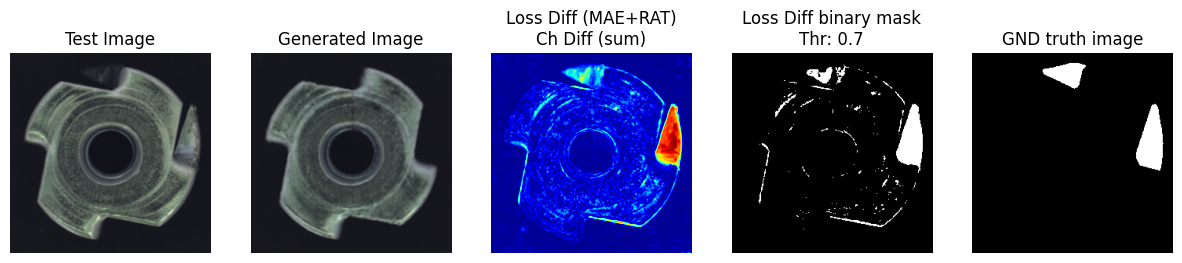

Pixel-wise Precision = 0.67400
Pixel-wise Recall = 0.74327
Pixel-wise F1 score = 0.70694
Sketchy IoU = 0.54672
Mean IoU = 0.75872


In [59]:
TEST_IMG_IX = 0
BINARY_MASK_THR = 0.7  # experiment['BIN_MASK_THRSD']

plot_save_dir = os.path.join(os.path.abspath(exp_save_dir), f"Loss_MAE_RAT_diff_thr_{str(BINARY_MASK_THR)}__{str(TEST_IMG_IX)}.png")

if experiment['USE_ENTIRE_IMAGES'] == True:
    visualize_loss_diff_binary_mask(image=unpartitioned_test_imgs[TEST_IMG_IX], gnd_image=ground_truth_images[TEST_IMG_IX],
                                model=custom_model, threshold=BINARY_MASK_THR, loss="MAE+RAT", channel_diff="sum")
else:  # Use test images to generate reconstructed images from the custom model, not unpartitioned_images
    visualize_loss_diff_binary_mask(image=test_imgs[preindex():postindex()], gnd_image=ground_truth_images[TEST_IMG_IX],
                                model=custom_model, threshold=BINARY_MASK_THR, loss="MAE+RAT", channel_diff="sum", save_as=plot_save_dir)

1/1 [==============================] - 0s 420ms/step


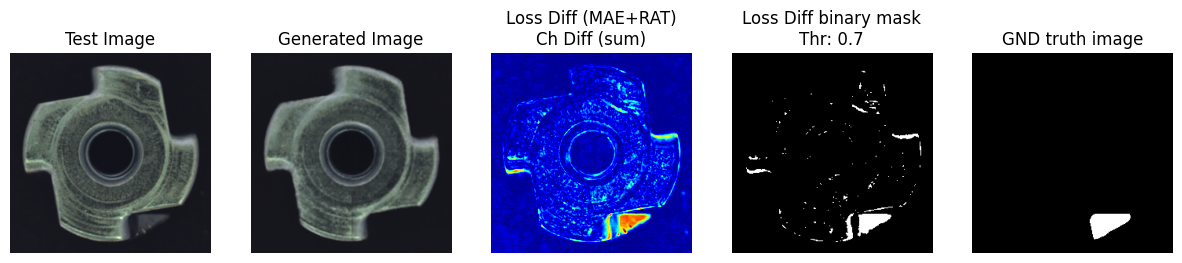

Pixel-wise Precision = 0.42431
Pixel-wise Recall = 0.65201
Pixel-wise F1 score = 0.51408
Sketchy IoU = 0.34597
Mean IoU = 0.66260


In [60]:
TEST_IMG_IX = 1
BINARY_MASK_THR = 0.7  # experiment['BIN_MASK_THRSD']

plot_save_dir = os.path.join(os.path.abspath(exp_save_dir), f"Loss_MAE_RAT_diff_thr_{str(BINARY_MASK_THR)}__{str(TEST_IMG_IX)}.png")

if experiment['USE_ENTIRE_IMAGES'] == True:
    visualize_loss_diff_binary_mask(image=unpartitioned_test_imgs[TEST_IMG_IX], gnd_image=ground_truth_images[TEST_IMG_IX],
                                model=custom_model, threshold=BINARY_MASK_THR, loss="MAE+RAT", channel_diff="sum")
else:  # Use test images to generate reconstructed images from the custom model, not unpartitioned_images
    visualize_loss_diff_binary_mask(image=test_imgs[preindex():postindex()], gnd_image=ground_truth_images[TEST_IMG_IX],
                                model=custom_model, threshold=BINARY_MASK_THR, loss="MAE+RAT", channel_diff="sum", save_as=plot_save_dir)

1/1 [==============================] - 0s 395ms/step


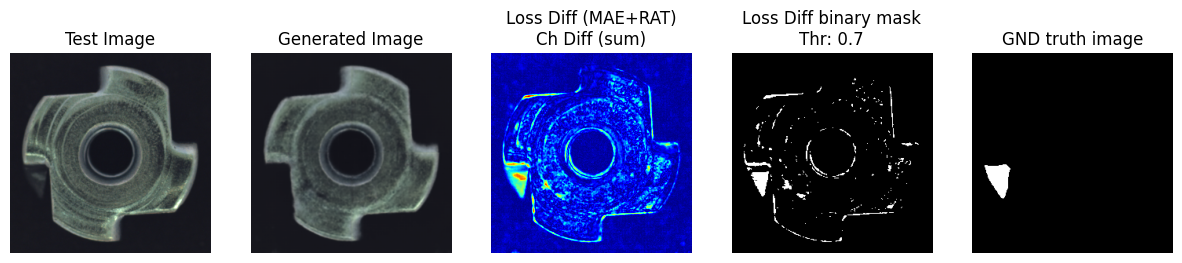

Pixel-wise Precision = 0.22038
Pixel-wise Recall = 0.51422
Pixel-wise F1 score = 0.30853
Sketchy IoU = 0.18241
Mean IoU = 0.57564


In [61]:
TEST_IMG_IX = 6
BINARY_MASK_THR = 0.7  # experiment['BIN_MASK_THRSD']

plot_save_dir = os.path.join(os.path.abspath(exp_save_dir), f"Loss_MAE_RAT_diff_thr_{str(BINARY_MASK_THR)}__{str(TEST_IMG_IX)}.png")

if experiment['USE_ENTIRE_IMAGES'] == True:
    visualize_loss_diff_binary_mask(image=unpartitioned_test_imgs[TEST_IMG_IX], gnd_image=ground_truth_images[TEST_IMG_IX],
                                model=custom_model, threshold=BINARY_MASK_THR, loss="MAE+RAT", channel_diff="sum")
else:  # Use test images to generate reconstructed images from the custom model, not unpartitioned_images
    visualize_loss_diff_binary_mask(image=test_imgs[preindex():postindex()], gnd_image=ground_truth_images[TEST_IMG_IX],
                                model=custom_model, threshold=BINARY_MASK_THR, loss="MAE+RAT", channel_diff="sum", save_as=plot_save_dir)

1/1 [==============================] - 0s 418ms/step


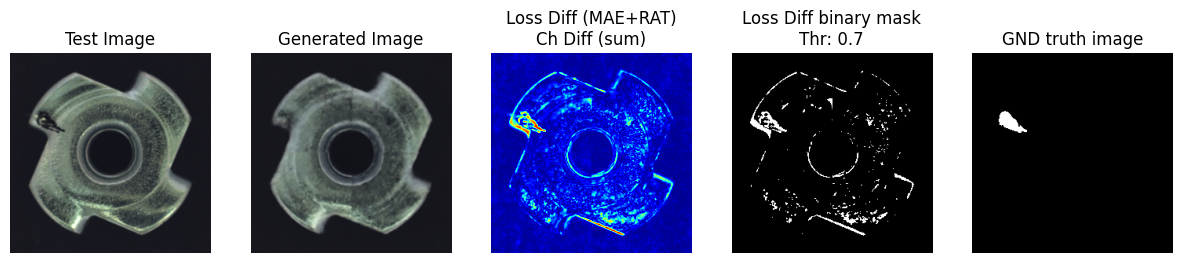

Pixel-wise Precision = 0.12997
Pixel-wise Recall = 0.60124
Pixel-wise F1 score = 0.21373
Sketchy IoU = 0.11965
Mean IoU = 0.54342


In [62]:
TEST_IMG_IX = 31
BINARY_MASK_THR = 0.7  # experiment['BIN_MASK_THRSD']

plot_save_dir = os.path.join(os.path.abspath(exp_save_dir), f"Loss_MAE_RAT_diff_thr_{str(BINARY_MASK_THR)}__{str(TEST_IMG_IX)}.png")

if experiment['USE_ENTIRE_IMAGES'] == True:
    visualize_loss_diff_binary_mask(image=unpartitioned_test_imgs[TEST_IMG_IX], gnd_image=ground_truth_images[TEST_IMG_IX],
                                model=custom_model, threshold=BINARY_MASK_THR, loss="MAE+RAT", channel_diff="sum")
else:  # Use test images to generate reconstructed images from the custom model, not unpartitioned_images
    visualize_loss_diff_binary_mask(image=test_imgs[preindex():postindex()], gnd_image=ground_truth_images[TEST_IMG_IX],
                                model=custom_model, threshold=BINARY_MASK_THR, loss="MAE+RAT", channel_diff="sum", save_as=plot_save_dir)

In [63]:
def compute_generated_image_loss_diff(image, gen_image, loss="MAE+RAT", channel_diff="sum", threshold=0.5, eps=1e-8):
    # Compute Loss diff between test and generated images (Use MAE or MSE)
    if "MAE" in loss:
        loss_diff = tf.abs(image - gen_image)       # MAE
    else:
        loss_diff = tf.square(image - gen_image)    # MSE

    # Rational Loss diff
    if "RAT" in loss:
        # Overlay test image and the generated image
        overlayed_image = gen_image + image + eps
        # Compute rational loss diff
        rational_loss_diff = loss_diff / overlayed_image
    else:
        rational_loss_diff = loss_diff

    # RGB to gray-scale
    assert ((channel_diff=="sum") or (channel_diff=="logic_or"))
    if channel_diff == "sum":
        # Sum the differences across channels
        rational_loss_diff = tf.reduce_sum(rational_loss_diff, axis=-1)
        rational_loss_diff_gray = tf.cast(rational_loss_diff > threshold, tf.uint8)  # Binary mask
    else:  # logic_or
        # Combine the results along the channel axis - Computes tf.math.logical_or of elements across dimensions of a tensor
        rational_loss_diff = tf.reduce_any((rational_loss_diff > threshold), axis=-1)
        # Convert it to the grayscale image
        rational_loss_diff_gray = tf.cast(rational_loss_diff, tf.uint8)  # Binary mask

    return  rational_loss_diff_gray

ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) metric

AUC:  0.894004848334162
No-skill AUC:  0.5



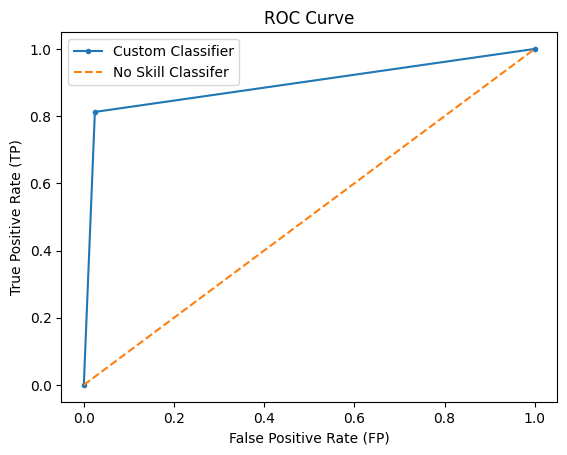

In [109]:
TEST_IMG_IX = 3
BINARY_MASK_THR = 0.7  # experiment['BIN_MASK_THRSD']

# Convert Ground Truth Image to the Binary mask format image
X_Gnd_bin = tf.expand_dims(ground_truth_images[TEST_IMG_IX, :, :,0], axis=-1)
# Reshape groud truth image
X_Gnd_bin_flat = (tf.cast(tf.reshape(X_Gnd_bin, [-1]), dtype=tf.int32)).numpy()

loss_diff_gray = compute_generated_image_loss_diff(unpartitioned_test_imgs[TEST_IMG_IX],
                                                  unpartitioned_generated_test_imgs[TEST_IMG_IX],
                                                  loss="MAE+RAT", channel_diff="sum",
                                                  threshold=BINARY_MASK_THR)
# Reshape diff gray
loss_diff_gray
loss_diff_gray_flat = (tf.cast(tf.reshape(loss_diff_gray, [-1]), dtype=tf.int32)).numpy()

vision.show_ROC_score(X_Gnd_bin_flat, loss_diff_gray_flat, plot=True)

#### Evaluation Results for whole dataset

Prepare Evaluation Report

In [114]:
from sklearn.metrics import roc_auc_score

def prepare_evaluation_report(images, gen_images, gnd_images, bin_mask_thr=0.5, loss="MAE", channel_diff="sum", eps=1e-6, file="evaluation_report.txt"):
    mean_iou = []
    mean_precision = []
    mean_recall= []
    mean_f1 = []
    mean_auc = []
    report_txt = ""

    # Convert ground truth image to the binary format
    if len(gnd_images.shape) == 4 and gnd_images.shape[-1] == 3:
        gnd_images = gnd_images[:,:,:,0]  # Get only one channel content
    elif len(gnd_images.shape) < 4:
        raise ValueError('Make sure that your dimension is 4d (batch_size, width, height, channels)')

    assert ((loss=="MAE") or (loss=="MSE") or (loss=="MAE+RAT") or (loss=="MSE+RAT"))

    # Compute Loss diff between test and generated images (Use MAE or MSE)
    if "MAE" in loss:
        loss_diff = tf.abs(images - gen_images)       # MAE
    else:
        loss_diff = tf.square(images - gen_images)    # MSE

    # Rational Loss diff
    if "RAT" in loss:
        # Overlay test image and the generated image
        overlayed_image = gen_images + images + eps
        # Compute rational loss diff
        rational_loss_diff = loss_diff / overlayed_image
    else:
        rational_loss_diff = loss_diff

    # RGB to gray-scale
    assert ((channel_diff=="sum") or (channel_diff=="logic_or"))
    if channel_diff == "sum":
        # Sum the differences across channels
        rational_loss_diff = tf.reduce_sum(rational_loss_diff, axis=-1)
        rational_loss_diff_gray = tf.cast(rational_loss_diff > bin_mask_thr, tf.uint8)  # Binary mask
    else:  # logic_or
        # Combine the results along the channel axis - Computes tf.math.logical_or of elements across dimensions of a tensor
        rational_loss_diff = tf.reduce_any((rational_loss_diff > bin_mask_thr), axis=-1)
        # Convert it to the grayscale image
        rational_loss_diff_gray = tf.cast(rational_loss_diff, tf.uint8)  # Binary mask

    # Record all evaluation metrics
    with open(file, "a") as eval_report:
        report_txt = f"====== Experiment {exp_save_dir.split('experiment_')[1]} Evaluation Report ======\n"
        report_txt += "=== Configs ===\n"
        utils.write_dict_to_file(experiment, file, head=report_txt)
        report_txt = "\n=== Evaluation ===\n"
        report_txt += f"Number of test images: {len(gnd_images)}\n"
        report_txt += f"Binary mask Threshold: {bin_mask_thr}\n"
        report_txt += f"Loss difference computation method: {loss}\n"
        report_txt += f"Channel value pooling method: {channel_diff}\n\n"

        for ix, (gnd_image, rat_diff_image) in enumerate(zip(gnd_images, rational_loss_diff_gray)):
            px_IoU = vision.PixelWiseIoU(tf.cast(gnd_image, tf.uint8), rat_diff_image)
            mean_iou.append(px_IoU.calculate_mean_iou())
            mean_recall.append(px_IoU.calculate_px_wise_recall())
            mean_precision.append(px_IoU.calculate_px_wise_precision())
            mean_f1.append(px_IoU.calculate_px_wise_f1_score())
            report_txt += (f"{ix}.Test Image\n")
            report_txt += (f"Mean IoU = {mean_iou[ix]:.5f}\n")
            report_txt += (f"Pixel-wise Recall = {mean_recall[ix]:.5f}\n")
            report_txt += (f"Pixel-wise Precision = {mean_precision[ix]:.5f}\n")
            report_txt += (f"Pixel-wise F1 score = {mean_f1[ix]:.5f}\n")

            gnd_image_flat = (tf.cast(tf.reshape(gnd_image, [-1]), dtype=tf.int32)).numpy()
            rat_diff_image_flat = (tf.cast(tf.reshape(rat_diff_image, [-1]), dtype=tf.int32)).numpy()
            mean_auc.append(roc_auc_score(gnd_image_flat, rat_diff_image_flat))
            report_txt += (f"AUC score = {mean_auc[ix]:.5f}\n\n")

        report_txt += "========================\n\n"
        report_txt += (f"Mean IoU: {sum(mean_iou) / len(mean_iou):.5f}\n")
        report_txt += (f"Mean Recall: {sum(mean_recall) / len(mean_recall):.5f}\n")
        report_txt += (f"Mean Precision: {sum(mean_precision) / len(mean_precision):.5f}\n")
        report_txt += (f"Mean F1 score: {sum(mean_f1) / len(mean_f1):.5f}\n")
        report_txt += (f"Mean AUC score: {sum(mean_auc) / len(mean_auc):.5f}")
        eval_report.write(report_txt)

    print(f"Binary mask Threshold: {bin_mask_thr}")
    print(f"Loss difference computation method: {loss}")
    print(f"Channel value pooling method: {channel_diff}")
    print(f"Mean IoU: {sum(mean_iou) / len(mean_iou):.5f}")
    print(f"Mean Recall: {sum(mean_recall) / len(mean_recall):.5f}")
    print(f"Mean Precision: {sum(mean_precision) / len(mean_precision):.5f}")
    print(f"Mean F1 score: {sum(mean_f1) / len(mean_f1):.5f}")
    print(f"Mean AUC score: {sum(mean_auc) / len(mean_auc):.5f}")

    return (rational_loss_diff_gray)

Save eval report to the Google Drive

In [115]:
eval_report_save_dir = os.path.join(exp_save_dir, "evaluation_report.txt")

losses = prepare_evaluation_report(unpartitioned_test_imgs, unpartitioned_generated_test_imgs,
                                   ground_truth_images, bin_mask_thr=0.7, loss="MAE+RAT",
                                   channel_diff="sum", file=eval_report_save_dir)

Binary mask Threshold: 0.7
Loss difference computation method: MAE+RAT
Channel value pooling method: sum
Mean IoU: 0.51993
Mean Recall: 0.33018
Mean Precision: 0.39921
Mean F1 score: 0.29075
Mean AUC score: 0.65250


GradCAM visualize

In [ ]:
'''
gradCAM = vision.GradCAM_AE(custom_model, "conv2d_layer_res_cbam_1") # conv2d_layer_res_cbam_1

X_test_gen = tf.squeeze(custom_model.predict(tf.expand_dims(X_test, axis=0)))

(heatmap, output) = gradCAM(np.expand_dims(X_test, axis=0), X_test*255, alpha=0.4)
(heatmap_gen, output_gen) = gradCAM(np.expand_dims(X_test_gen, axis=0), X_test_gen*255, alpha=0.4)

fig = plt.figure(figsize=(12,10))
plt.subplot(2,3,1)
plt.imshow(X_test)
plt.title("Original")
plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(heatmap)
plt.title("Heatmap")
plt.axis('off')
plt.subplot(2,3,3)
plt.imshow(output)
plt.title("Superimposed")
plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(X_test_gen)
plt.title("Original")
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(heatmap_gen)
plt.title("Heatmap_gen")
plt.axis('off')
plt.subplot(2,3,6)
plt.imshow(output_gen)
plt.title("Superimposed")
plt.axis('off')
plt.show()
'''

### Evaluation End

In [ ]:
#from google.colab import runtime
#runtime.unassign()